<a href="https://colab.research.google.com/github/lunacandido/deep_learning_pytorch_luna/blob/main/Dataloader_trainingflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregamento de dados e Fluxo de treinamento

O treinamento é um processo iterativo que segue o seguinte fluxo:

Operar a entrada na rede, calcular função de perda, calcular o gradiente e atualizar os pesos,
ou seja, consiste em passo de otimização.

Batch é a quantidade de amostras vistas numa iteração. Já a época é quando todas as amostras do conjuntos de treino foram vistas pelo modelo, ou seja, iterou o suficiente pra ver todas as amostras de treino. E a cada nova época se refina o modelo.

Obs: o gráfico de convergencia é definido com base na época.

In [ ]:

import torch
from torch import nn , optim
## trabalhando com datasets de imagem
from torchvision import datasets
from torchvision import transforms 
## importando matplot
import matplotlib.pyplot as plt
import numpy as np
import time

args = {
    'batch_size': 20,
    'num_workers' : 4,
    'lr': 1e-4,
    'weight_decay':5e-4,
    'num_epochs': 2
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

## importando o datasets de interesse
treino_set = datasets.MNIST('./', 
                      train=True, 
                      transform=transforms.ToTensor(),
                      download=True)
teste_set = datasets.MNIST('./',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(treino_set)) + '\nAmostras de Teste:' + str(len(teste_set)))
print(type(treino_set)) ## classe do datasets
print(type(treino_set[0])) ## o item de qualquer dataset será uma tupla - (dado, rótulo)
print(treino_set[0]) ## imprimindo a tupla para visualização


for i in range(4):
  dado, rotulo = treino_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

# transforms.RandomCrop(n) = realiza 'n' recortes na mesma imagem
# basta trocar transforms.ToTensor() por transforms.RandomCrop(n)



# Data loader

- Separa os dados em batches
- Embaralha os dados
- Carrega batches em paralelo utilizando threads

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([20, 1, 28, 28]) torch.Size([20])


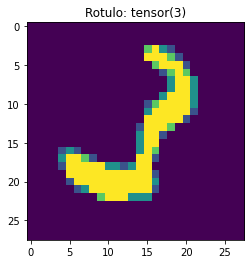

In [3]:
## importar o pacote do data loader
from torch.utils.data import DataLoader
## criando os batchs
treino_loader = DataLoader(treino_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, # para embaralhar
                          num_workers=args['num_workers'])

teste_loader = DataLoader(teste_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])
# data loader não pode ser indexado
# precisa de comando de iteração
# para construir um batch a amostra deve ser tensorial
for batch in treino_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break
  ## 20 amostra de tamanho 28 por 28

### Fazendo o fluxo de treinamento completo

In [8]:
# Implementando MLP

class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):
    
    X = X.view(X.size(0), -1)

    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output

input_size  = 28 * 28
hidden_size = 128
out_size    = 10 #classes

torch.manual_seed(42)
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU 

In [9]:
## Loss

criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
# fluxo
for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in treino_loader:
    dado, rotulo = batch
    # cast 
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    # foward
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backward
    loss.backward()
    optimizer.step()
  epoch_loss = np.asarray(epoch_loss)
  end = time.time()

  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoca 0, Loss: 1.8603 +\- 0.1100, Tempo: 25.74
